In [ ]:
# INSTALLATION REQUIREMENTS AND ENVIRONMENT SETUP
# Run this cell first to install all required packages

import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        return True
    except subprocess.CalledProcessError:
        return False

# Fix for astropy/hrv-analysis compatibility issue
def fix_astropy_compatibility():
    """Patch astropy compatibility for hrv-analysis"""
    try:
        # Check if astropy is installed and LombScargle location
        import astropy
        print(f"Astropy version: {astropy.__version__}")
        
        # Try importing LombScargle from the old location
        try:
            from astropy.stats import LombScargle
            print("✓ LombScargle available in astropy.stats (older astropy version)")
        except ImportError:
            try:
                from astropy.timeseries import LombScargle
                print("✓ LombScargle available in astropy.timeseries (newer astropy version)")
                
                # Apply monkey patch for hrv-analysis compatibility
                import astropy.stats
                astropy.stats.LombScargle = LombScargle
                print("✓ Applied compatibility patch for hrv-analysis")
                
            except ImportError:
                print("⚠ LombScargle not found in astropy")
                
    except ImportError:
        print("⚠ Astropy not installed")

# List of required packages with compatible versions
packages = [
    'pandas>=1.3.0',
    'numpy>=1.20.0',
    'matplotlib>=3.3.0',
    'seaborn>=0.11.0',
    'scipy>=1.7.0',
    'statsmodels>=0.12.0',
    'neurokit2>=0.2.0',
    'heartpy>=1.2.0',
    'astropy<5.0',  # Compatible version for hrv-analysis
    'hrv-analysis>=1.0.0',
    'scikit-learn>=1.0.0'
]

print("Installing required packages...")
print("="*50)

success_count = 0
for package in packages:
    if install_package(package):
        print(f"✓ Successfully installed: {package}")
        success_count += 1
    else:
        print(f"✗ Failed to install {package}")

print(f"\nInstallation complete! {success_count}/{len(packages)} packages installed successfully.")
print("\nApplying compatibility fixes...")
fix_astropy_compatibility()
print("Please restart the kernel after installation to ensure all packages are properly loaded.")


Installing required packages...
✓ Successfully installed: pandas>=1.3.0
✓ Successfully installed: numpy>=1.20.0
✓ Successfully installed: matplotlib>=3.3.0
✓ Successfully installed: seaborn>=0.11.0
✓ Successfully installed: scipy>=1.7.0
✓ Successfully installed: statsmodels>=0.12.0
✓ Successfully installed: neurokit2>=0.2.0
✓ Successfully installed: heartpy>=1.2.0
✓ Successfully installed: hrv-analysis>=1.0.0
✓ Successfully installed: scikit-learn>=1.0.0

Installation complete! 10/10 packages installed successfully.
Please restart the kernel after installation to ensure all packages are properly loaded.


In [12]:
# ASTROPY COMPATIBILITY FIX FOR HRV-ANALYSIS
# Run this cell if you get "cannot import name 'LombScargle' from 'astropy.stats'" error

print("APPLYING ASTROPY COMPATIBILITY FIX")
print("=" * 40)

def apply_astropy_patch():
    """Apply compatibility patch for hrv-analysis with newer astropy versions"""
    try:
        import astropy
        print(f"Astropy version detected: {astropy.__version__}")
        
        # Check if LombScargle is in the old location (astropy < 3.1)
        try:
            from astropy.stats import LombScargle
            print("✓ LombScargle found in astropy.stats (compatible)")
            return True
        except ImportError:
            # Try the new location (astropy >= 3.1)
            try:
                from astropy.timeseries import LombScargle
                print("✓ LombScargle found in astropy.timeseries (newer astropy)")
                
                # Apply monkey patch to make hrv-analysis work
                import astropy.stats
                astropy.stats.LombScargle = LombScargle
                print("✓ Applied compatibility patch - hrv-analysis should now work")
                return True
                
            except ImportError:
                print("✗ LombScargle not found in either location")
                return False
                
    except ImportError:
        print("⚠ Astropy not installed")
        return False

# Apply the patch
patch_successful = apply_astropy_patch()

if patch_successful:
    print("\n✓ Compatibility patch applied successfully!")
    print("You can now proceed with the HRV analysis.")
else:
    print("\n⚠ Patch failed. Alternative solutions:")
    print("1. Install compatible astropy version: pip install 'astropy<3.1'")
    print("2. Use alternative HRV libraries (HeartPy, NeuroKit2)")
    print("3. The notebook will fall back to basic HRV calculations")

print("\nProceeding with library imports...")


APPLYING ASTROPY COMPATIBILITY FIX
Astropy version detected: 7.1.0
✓ LombScargle found in astropy.timeseries (newer astropy)
✓ Applied compatibility patch - hrv-analysis should now work

✓ Compatibility patch applied successfully!
You can now proceed with the HRV analysis.

Proceeding with library imports...


In [13]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis
from scipy.stats import normaltest, levene, ttest_ind, f_oneway, pearsonr
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# HRV analysis libraries with proper error handling
print("IMPORTING HRV ANALYSIS LIBRARIES")
print("=" * 35)

nk = None
hr_analysis_available = False
hp = None
pyhrv_available = False
get_poincare_plot = None

# Try NeuroKit2 (recommended)
try:
    import neurokit2 as nk
    print("✓ NeuroKit2 imported successfully")
except ImportError as e:
    print(f"✗ NeuroKit2 not available: {e}")
    nk = None

# Try HeartPy (recommended alternative)
try:
    import heartpy as hp
    print("✓ HeartPy imported successfully")
except ImportError as e:
    print(f"✗ HeartPy not available: {e}")
    hp = None

# Try PyHRV (new alternative)
try:
    import pyhrv
    pyhrv_available = True
    print("✓ PyHRV imported successfully")
except ImportError as e:
    print(f"✗ PyHRV not available: {e}")
    pyhrv_available = False

# Try HRV-Analysis (may have astropy issues)
try:
    from hrvanalysis import get_time_domain_features, get_frequency_domain_features
    from hrvanalysis import remove_outliers, interpolate_nan_values, remove_ectopic_beats
    
    # Try to import poincare_plot - it might not be available in older versions
    try:
        from hrvanalysis import get_poincare_plot
        print("✓ HRV-Analysis imported successfully (with Poincaré)")
    except ImportError:
        print("✓ HRV-Analysis imported successfully (without Poincaré - will use manual calculation)")
        get_poincare_plot = None
    
    hr_analysis_available = True
except ImportError as e:
    print(f"✗ HRV-Analysis not available: {e} (this is expected due to astropy compatibility)")
    hr_analysis_available = False

# Visualization
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("\nLibrary versions:")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
import matplotlib
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"SciPy: {scipy.__version__}")
if nk: print(f"NeuroKit2: {nk.__version__}")
if hp: print(f"HeartPy: {hp.__version__}")

print("\n" + "="*50)
print("HRV Analysis Environment Ready!")
print("="*50)

# Check if we can proceed with analysis
if hr_analysis_available or nk is not None or hp is not None:
    print("✓ At least one HRV analysis library is available")
else:
    print("⚠ No HRV analysis libraries available")
    print("Will use basic HRV calculations with scipy and numpy")

# Basic HRV functions if libraries are not available
def calculate_basic_hrv(rr_intervals):
    """Calculate basic HRV metrics using numpy and scipy"""
    rr_intervals = np.array(rr_intervals)
    
    # Time domain metrics
    mean_nn = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals, ddof=1)
    
    # Calculate successive differences
    diff_nn = np.diff(rr_intervals)
    rmssd = np.sqrt(np.mean(diff_nn ** 2))
    
    # pNN50 - percentage of successive differences > 50ms
    pnn50 = np.sum(np.abs(diff_nn) > 50) / len(diff_nn) * 100
    
    # Poincaré plot metrics
    sd1 = np.std(diff_nn, ddof=1) / np.sqrt(2)
    sd2 = np.sqrt(2 * sdnn**2 - sd1**2) if sdnn > 0 else 0
    
    return {
        'mean_nni': mean_nn,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'pnni_50': pnn50,
        'sd1': sd1,
        'sd2': sd2,
        'sd2_sd1': sd2/sd1 if sd1 != 0 else 0,
        'lf': 0,  # Placeholder for frequency domain
        'hf': 0,
        'lf_hf_ratio': 0,
        'lf_nu': 0,
        'hf_nu': 0
    }

def calculate_poincare_metrics(rr_intervals):
    """Calculate Poincaré plot metrics manually"""
    rr_intervals = np.array(rr_intervals)
    diff_nn = np.diff(rr_intervals)
    
    # SD1 and SD2 calculation
    sd1 = np.std(diff_nn, ddof=1) / np.sqrt(2)
    sdnn = np.std(rr_intervals, ddof=1)
    sd2 = np.sqrt(2 * sdnn**2 - sd1**2) if sdnn > 0 else 0
    
    return {
        'sd1': sd1,
        'sd2': sd2,
        'sd1_sd2': sd1/sd2 if sd2 != 0 else 0
    }

print("Basic HRV calculation functions available as backup")


IMPORTING HRV ANALYSIS LIBRARIES
✓ NeuroKit2 imported successfully
✓ HeartPy imported successfully
✗ PyHRV not available: No module named 'pyhrv'
✓ HRV-Analysis imported successfully (without Poincaré - will use manual calculation)

Library versions:
Pandas: 2.2.3
NumPy: 1.26.4
Matplotlib: 3.10.1
Seaborn: 0.13.2
SciPy: 1.15.2
NeuroKit2: 0.2.12
HeartPy: Version 1.2.6

HRV Analysis Environment Ready!
✓ At least one HRV analysis library is available
Basic HRV calculation functions available as backup


In [14]:
# Define participant files with correct paths
participants = {
    'T01_Mara': '../T01_Mara.csv',
    'T02_Laura': '../T02_Laura.csv',
    'T03_Nancy': '../T03_Nancy.csv',
    'T04_Michelle': '../T04_Michelle.csv',
    'T05_Felicitas': '../T05_Felicitas.csv',
    'T06_Mara_Selena': '../T06_Mara_Selena.csv',
    'T07_Geraldinn': '../T07_Geraldinn.csv',
    'T08_Karina': '../T08_Karina.csv'
}

# Load all participant data
participant_data = {}
print("LOADING PARTICIPANT DATA")
print("="*30)

for participant_id, file_path in participants.items():
    try:
        df = pd.read_csv(file_path)
        participant_data[participant_id] = df
        print(f"✓ Loaded {participant_id}: {len(df):,} records")
    except FileNotFoundError:
        print(f"✗ File not found for {participant_id}: {file_path}")
    except Exception as e:
        print(f"✗ Error loading {participant_id}: {e}")

# Display data structure if any data was loaded
if participant_data:
    sample_data = list(participant_data.values())[0]
    print(f"\nDataset columns ({len(sample_data.columns)}):")
    for i, col in enumerate(sample_data.columns):
        print(f"  {i+1:2}. {col}")
    
    print(f"\nSample data preview:")
    print(sample_data.head(3))
    
    print(f"\nData types:")
    print(sample_data.dtypes)
else:
    print("\n⚠ No data loaded successfully!")
    print("Please check file paths and ensure CSV files exist in the working folder.")


LOADING PARTICIPANT DATA
✓ Loaded T01_Mara: 648,029 records
✓ Loaded T02_Laura: 233,918 records
✓ Loaded T03_Nancy: 126,588 records
✓ Loaded T04_Michelle: 89,442 records
✓ Loaded T05_Felicitas: 173,434 records
✓ Loaded T06_Mara_Selena: 144,295 records
✓ Loaded T07_Geraldinn: 94,301 records
✓ Loaded T08_Karina: 57,872 records

Dataset columns (16):
   1. Sol
   2. user
   3. source_file
   4. time [s/1000]
   5. breathing_rate [rpm]
   6. SPO2 [%]
   7. PTT [s]
   8. minute_ventilation [mL/min]
   9. systolic_pressure [mmHg]
  10. energy_mifflin_keytel [watt]
  11. sleep_position [NA]
  12. temperature [NA]
  13. activity [g]
  14. temperature_celcius [C]
  15. heart_rate [bpm]
  16. cadence [spm]

Sample data preview:
   Sol      user      source_file  time [s/1000]  breathing_rate [rpm]  \
0    2  T01_Mara  record_4494.csv   1.732544e+12                   NaN   
1    2  T01_Mara  record_4494.csv   1.732544e+12                   NaN   
2    2  T01_Mara  record_4494.csv   1.732544e+12  

In [15]:
# Extract heart rate data for each participant
hr_data = {}
rr_data = {}

print("HEART RATE DATA EXTRACTION AND QUALITY ASSESSMENT")
print("=" * 55)

for participant_id, df in participant_data.items():
    print(f"\n{participant_id}:")
    print("-" * 15)
    
    # Extract heart rate data (remove NaN values)
    if 'heart_rate [bpm]' in df.columns:
        hr_clean = df['heart_rate [bpm]'].dropna()
        time_clean = df.loc[hr_clean.index, 'time [s/1000]'] if 'time [s/1000]' in df.columns else None
        
        # Convert to RR intervals (ms) - only for valid HR values
        valid_hr_mask = (hr_clean >= 40) & (hr_clean <= 200)
        valid_hr = hr_clean[valid_hr_mask]
        
        if len(valid_hr) > 0:
            rr_intervals = (60000 / valid_hr).values  # Convert BPM to RR intervals in ms
            
            # Store data
            hr_data[participant_id] = {
                'heart_rate': valid_hr.values,
                'timestamps': time_clean.iloc[valid_hr_mask.values].values if time_clean is not None else None,
                'n_samples': len(valid_hr)
            }
            
            # Quality assessment
            quality_ratio = len(valid_hr) / len(hr_clean) * 100 if len(hr_clean) > 0 else 0
            
            print(f"  Total HR samples: {len(hr_clean):,}")
            print(f"  Valid HR samples: {len(valid_hr):,} ({quality_ratio:.1f}%)")
            print(f"  HR range: {valid_hr.min():.1f} - {valid_hr.max():.1f} bpm")
            print(f"  Mean HR: {valid_hr.mean():.1f} ± {valid_hr.std():.1f} bpm")
            
            # Store cleaned RR intervals (additional filtering)
            rr_filtered = rr_intervals[(rr_intervals >= 300) & (rr_intervals <= 1500)]  # Valid RR range
            rr_data[participant_id] = rr_filtered
            print(f"  Valid RR intervals: {len(rr_filtered):,}")
            
            # Calculate additional quality metrics
            rr_mean = np.mean(rr_filtered)
            rr_std = np.std(rr_filtered)
            print(f"  Mean RR interval: {rr_mean:.1f} ± {rr_std:.1f} ms")
            
        else:
            print(f"  ✗ No valid HR data found")
    else:
        print(f"  ✗ No 'heart_rate [bpm]' column found")

print(f"\nSUMMARY:")
print(f"Successfully processed {len(rr_data)} participants")
if rr_data:
    print(f"Participants with data: {', '.join(rr_data.keys())}")
    
    # Overall statistics
    all_rr = np.concatenate(list(rr_data.values()))
    print(f"\nOverall RR statistics:")
    print(f"  Total RR intervals: {len(all_rr):,}")
    print(f"  Mean RR: {np.mean(all_rr):.1f} ± {np.std(all_rr):.1f} ms")
    print(f"  RR range: {np.min(all_rr):.1f} - {np.max(all_rr):.1f} ms")
else:
    print("No participants with valid RR data")


HEART RATE DATA EXTRACTION AND QUALITY ASSESSMENT

T01_Mara:
---------------
  Total HR samples: 260,068
  Valid HR samples: 260,067 (100.0%)
  HR range: 40.0 - 189.0 bpm
  Mean HR: 87.6 ± 23.4 bpm
  Valid RR intervals: 260,067
  Mean RR interval: 732.4 ± 186.4 ms

T02_Laura:
---------------
  Total HR samples: 99,336
  Valid HR samples: 99,336 (100.0%)
  HR range: 46.0 - 195.0 bpm
  Mean HR: 75.6 ± 25.0 bpm
  Valid RR intervals: 99,336
  Mean RR interval: 859.1 ± 207.0 ms

T03_Nancy:
---------------
  Total HR samples: 126,580
  Valid HR samples: 126,266 (99.8%)
  HR range: 40.0 - 184.0 bpm
  Mean HR: 81.5 ± 18.0 bpm
  Valid RR intervals: 126,266
  Mean RR interval: 767.9 ± 147.2 ms

T04_Michelle:
---------------
  Total HR samples: 89,434
  Valid HR samples: 89,434 (100.0%)
  HR range: 55.0 - 140.0 bpm
  Mean HR: 85.9 ± 10.8 bpm
  Valid RR intervals: 89,434
  Mean RR interval: 709.8 ± 91.4 ms

T05_Felicitas:
---------------
  Total HR samples: 173,422
  Valid HR samples: 169,864 (97.

In [16]:
# HRV Analysis using available libraries or basic calculations
hrv_analysis_results = {}

print("HRV ANALYSIS USING AVAILABLE LIBRARIES")
print("=" * 50)

for participant_id, rr_intervals in rr_data.items():
    if len(rr_intervals) > 100:  # Minimum data requirement
        try:
            print(f"\n{participant_id}:")
            print("-" * 15)
            
            # Convert to list for processing
            rr_list = rr_intervals.tolist()
            
            if hr_analysis_available:
                # Use HRV-Analysis library
                print("  Using HRV-Analysis library")
                rr_cleaned = remove_outliers(rr_intervals=rr_list, low_rri=300, high_rri=1500)
                rr_cleaned = remove_ectopic_beats(rr_intervals=rr_cleaned, method="malik")
                rr_cleaned = interpolate_nan_values(rr_intervals=rr_cleaned)
                
                print(f"  Original RR intervals: {len(rr_list)}")
                print(f"  Cleaned RR intervals: {len(rr_cleaned)}")
                
                # Compute HRV metrics
                time_domain = get_time_domain_features(rr_cleaned)
                
                try:
                    frequency_domain = get_frequency_domain_features(rr_cleaned, method='welch', sampling_frequency=4)
                except:
                    frequency_domain = {'lf': 0, 'hf': 0, 'lf_hf_ratio': 0, 'lf_nu': 0, 'hf_nu': 0}
                    print("    (Frequency domain analysis failed, using basic metrics)")
                
                # Try to get Poincaré features
                if get_poincare_plot is not None:
                    try:
                        poincare_features = get_poincare_plot(rr_cleaned, show=False)
                    except:
                        poincare_features = calculate_poincare_metrics(rr_cleaned)
                        print("    (Using manual Poincaré calculation)")
                else:
                    poincare_features = calculate_poincare_metrics(rr_cleaned)
                    print("    (Using manual Poincaré calculation)")
                
                # Combine all metrics
                all_metrics = {**time_domain, **frequency_domain, **poincare_features}
                
            else:
                # Use basic HRV calculations
                print("  Using basic HRV calculations")
                # Simple outlier removal
                q1, q3 = np.percentile(rr_intervals, [25, 75])
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                rr_cleaned = rr_intervals[(rr_intervals >= lower_bound) & (rr_intervals <= upper_bound)]
                
                print(f"  Original RR intervals: {len(rr_intervals)}")
                print(f"  Cleaned RR intervals: {len(rr_cleaned)}")
                
                all_metrics = calculate_basic_hrv(rr_cleaned)
            
            hrv_analysis_results[participant_id] = all_metrics
            
            print(f"  Time-domain metrics:")
            print(f"    Mean NN: {all_metrics['mean_nni']:.2f} ms")
            print(f"    SDNN: {all_metrics['sdnn']:.2f} ms")
            print(f"    RMSSD: {all_metrics['rmssd']:.2f} ms")
            print(f"    pNN50: {all_metrics['pnni_50']:.2f}%")
            
            if hr_analysis_available and all_metrics.get('lf', 0) > 0:
                print(f"  Frequency-domain metrics:")
                print(f"    LF Power: {all_metrics['lf']:.2f} ms²")
                print(f"    HF Power: {all_metrics['hf']:.2f} ms²")
                print(f"    LF/HF Ratio: {all_metrics['lf_hf_ratio']:.2f}")
            else:
                print(f"  Frequency-domain metrics: Not available (simplified analysis)")
            
            print(f"  Poincaré metrics:")
            print(f"    SD1: {all_metrics['sd1']:.2f} ms")
            print(f"    SD2: {all_metrics['sd2']:.2f} ms")
            print(f"    SD2/SD1: {all_metrics.get('sd2_sd1', 0):.2f}")
            
        except Exception as e:
            print(f"  ✗ Error processing {participant_id}: {str(e)}")
    else:
        print(f"  ✗ Insufficient data for {participant_id}: {len(rr_intervals)} samples")

print(f"\nHRV Analysis completed for {len(hrv_analysis_results)} participants")
if hrv_analysis_results:
    print(f"Successfully analyzed: {', '.join(hrv_analysis_results.keys())}")
else:
    print("No participants successfully analyzed")


HRV ANALYSIS USING AVAILABLE LIBRARIES

T01_Mara:
---------------
  Using HRV-Analysis library
0 outlier(s) have been deleted.
156 ectopic beat(s) have been deleted with malik rule.
  Original RR intervals: 260067
  Cleaned RR intervals: 260067
    (Using manual Poincaré calculation)
  Time-domain metrics:
    Mean NN: 732.39 ms
    SDNN: 186.37 ms
    RMSSD: 9.51 ms
    pNN50: 0.33%
  Frequency-domain metrics:
    LF Power: 218.80 ms²
    HF Power: 21.38 ms²
    LF/HF Ratio: 10.23
  Poincaré metrics:
    SD1: 6.72 ms
    SD2: 263.48 ms
    SD2/SD1: 0.00

T02_Laura:
---------------
  Using HRV-Analysis library
0 outlier(s) have been deleted.
28 ectopic beat(s) have been deleted with malik rule.
  Original RR intervals: 99336
  Cleaned RR intervals: 99336
    (Using manual Poincaré calculation)
  Time-domain metrics:
    Mean NN: 859.07 ms
    SDNN: 207.05 ms
    RMSSD: 9.11 ms
    pNN50: 0.25%
  Frequency-domain metrics:
    LF Power: 167.14 ms²
    HF Power: 13.30 ms²
    LF/HF Ratio:

In [17]:
# Create comprehensive HRV results DataFrame
hrv_summary = []
hrv_df = None  # Initialize the DataFrame variable

if hrv_analysis_results:
    print("STATISTICAL ANALYSIS OF HRV METRICS")
    print("=" * 40)
    
    # Create DataFrame from results
    for participant_id in hrv_analysis_results.keys():
        metrics = hrv_analysis_results[participant_id]
        
        row = {
            'Participant': participant_id,
            'Mean_NN': metrics['mean_nni'],
            'SDNN': metrics['sdnn'],
            'RMSSD': metrics['rmssd'],
            'pNN50': metrics['pnni_50'],
            'LF_Power': metrics.get('lf', 0),
            'HF_Power': metrics.get('hf', 0),
            'LF_HF_Ratio': metrics.get('lf_hf_ratio', 0),
            'SD1': metrics['sd1'],
            'SD2': metrics['sd2'],
            'SD2_SD1': metrics.get('sd2_sd1', 0)
        }
        hrv_summary.append(row)
    
    hrv_df = pd.DataFrame(hrv_summary)
    
    print("\\n1. DESCRIPTIVE STATISTICS")
    print("-" * 30)
    print(hrv_df.describe().round(2))
    
    # Test normality for key HRV metrics
    print("\\n2. NORMALITY TESTING (D'Agostino-Pearson Test)")
    print("-" * 50)
    key_metrics = ['SDNN', 'RMSSD', 'pNN50', 'SD1', 'SD2']
    
    for metric in key_metrics:
        if metric in hrv_df.columns and len(hrv_df[metric].dropna()) > 3:
            stat, p_value = normaltest(hrv_df[metric].dropna())
            normality_status = "Normal" if p_value > 0.05 else "Non-normal"
            print(f"{metric:12}: D'Agostino-Pearson stat = {stat:.3f}, p = {p_value:.3f} ({normality_status})")
    
    # Correlation analysis
    print("\\n3. CORRELATION ANALYSIS")
    print("-" * 30)
    
    # Test specific correlations of interest
    correlations_of_interest = [
        ('SDNN', 'SD2'),
        ('RMSSD', 'SD1'),
        ('pNN50', 'RMSSD'),
        ('SD1', 'SD2')
    ]
    
    for metric1, metric2 in correlations_of_interest:
        if metric1 in hrv_df.columns and metric2 in hrv_df.columns:
            valid_data = hrv_df[[metric1, metric2]].dropna()
            if len(valid_data) > 2:
                r, p = pearsonr(valid_data[metric1], valid_data[metric2])
                significance = "significant" if p < 0.05 else "not significant"
                print(f"{metric1} vs {metric2}:")
                print(f"  Pearson r = {r:.3f}, p = {p:.3f} ({significance})")
    
    # Group analysis based on SDNN median
    print("\\n4. INTER-PARTICIPANT VARIABILITY ANALYSIS")
    print("-" * 45)
    
    if len(hrv_df) > 1:
        # Split participants into high and low HRV groups based on SDNN median
        sdnn_median = hrv_df['SDNN'].median()
        hrv_df['HRV_Group'] = hrv_df['SDNN'].apply(lambda x: 'High_HRV' if x > sdnn_median else 'Low_HRV')
        
        high_hrv = hrv_df[hrv_df['HRV_Group'] == 'High_HRV']
        low_hrv = hrv_df[hrv_df['HRV_Group'] == 'Low_HRV']
        
        print(f"Classification based on SDNN median ({sdnn_median:.2f} ms):")
        print(f"High HRV group (n={len(high_hrv)}): {', '.join(high_hrv['Participant'].tolist())}")
        print(f"Low HRV group (n={len(low_hrv)}): {', '.join(low_hrv['Participant'].tolist())}")
        
        # Display correlation matrix
        print("\\n5. CORRELATION MATRIX")
        print("-" * 22)
        numeric_cols = ['SDNN', 'RMSSD', 'pNN50', 'SD1', 'SD2']
        available_cols = [col for col in numeric_cols if col in hrv_df.columns]
        if available_cols:
            correlation_matrix = hrv_df[available_cols].corr()
            print(correlation_matrix.round(3))
    
    # Save results
    print("\\n6. RESULTS SUMMARY")
    print("-" * 20)
    print(f"Total participants analyzed: {len(hrv_df)}")
    print(f"HRV metrics computed: Time-domain, Poincaré plot metrics")
    print(f"Statistical tests performed: Normality, Correlation analysis")
    print(f"Results available in 'hrv_df' DataFrame for further analysis")
    
else:
    print("No HRV analysis results available for statistical analysis")
    print("Please run the HRV analysis sections first")


STATISTICAL ANALYSIS OF HRV METRICS
\n1. DESCRIPTIVE STATISTICS
------------------------------
       Mean_NN    SDNN  RMSSD  pNN50  LF_Power  HF_Power  LF_HF_Ratio    SD1  \
count     8.00    8.00   8.00   8.00      8.00      8.00         8.00   8.00   
mean    768.34  160.48  11.54   0.93    435.29     32.02        15.55   8.16   
std      53.14   43.64   5.45   1.51    361.97     35.99         4.08   3.86   
min     709.82   91.37   6.82   0.05    142.80      8.00        10.23   4.82   
25%     731.19  132.92   9.04   0.21    205.89     15.18        12.07   6.39   
50%     755.99  159.23   9.62   0.29    346.36     21.22        16.77   6.80   
75%     785.42  191.54  11.79   0.89    485.91     27.82        17.64   8.34   
max     859.07  220.02  24.38   4.57   1264.71    119.29        22.05  17.24   

          SD2  SD2_SD1  
count    8.00      8.0  
mean   226.77      0.0  
std     61.74      0.0  
min    129.06      0.0  
25%    187.79      0.0  
50%    224.79      0.0  
75%    27

GENERATING HRV VISUALIZATIONS


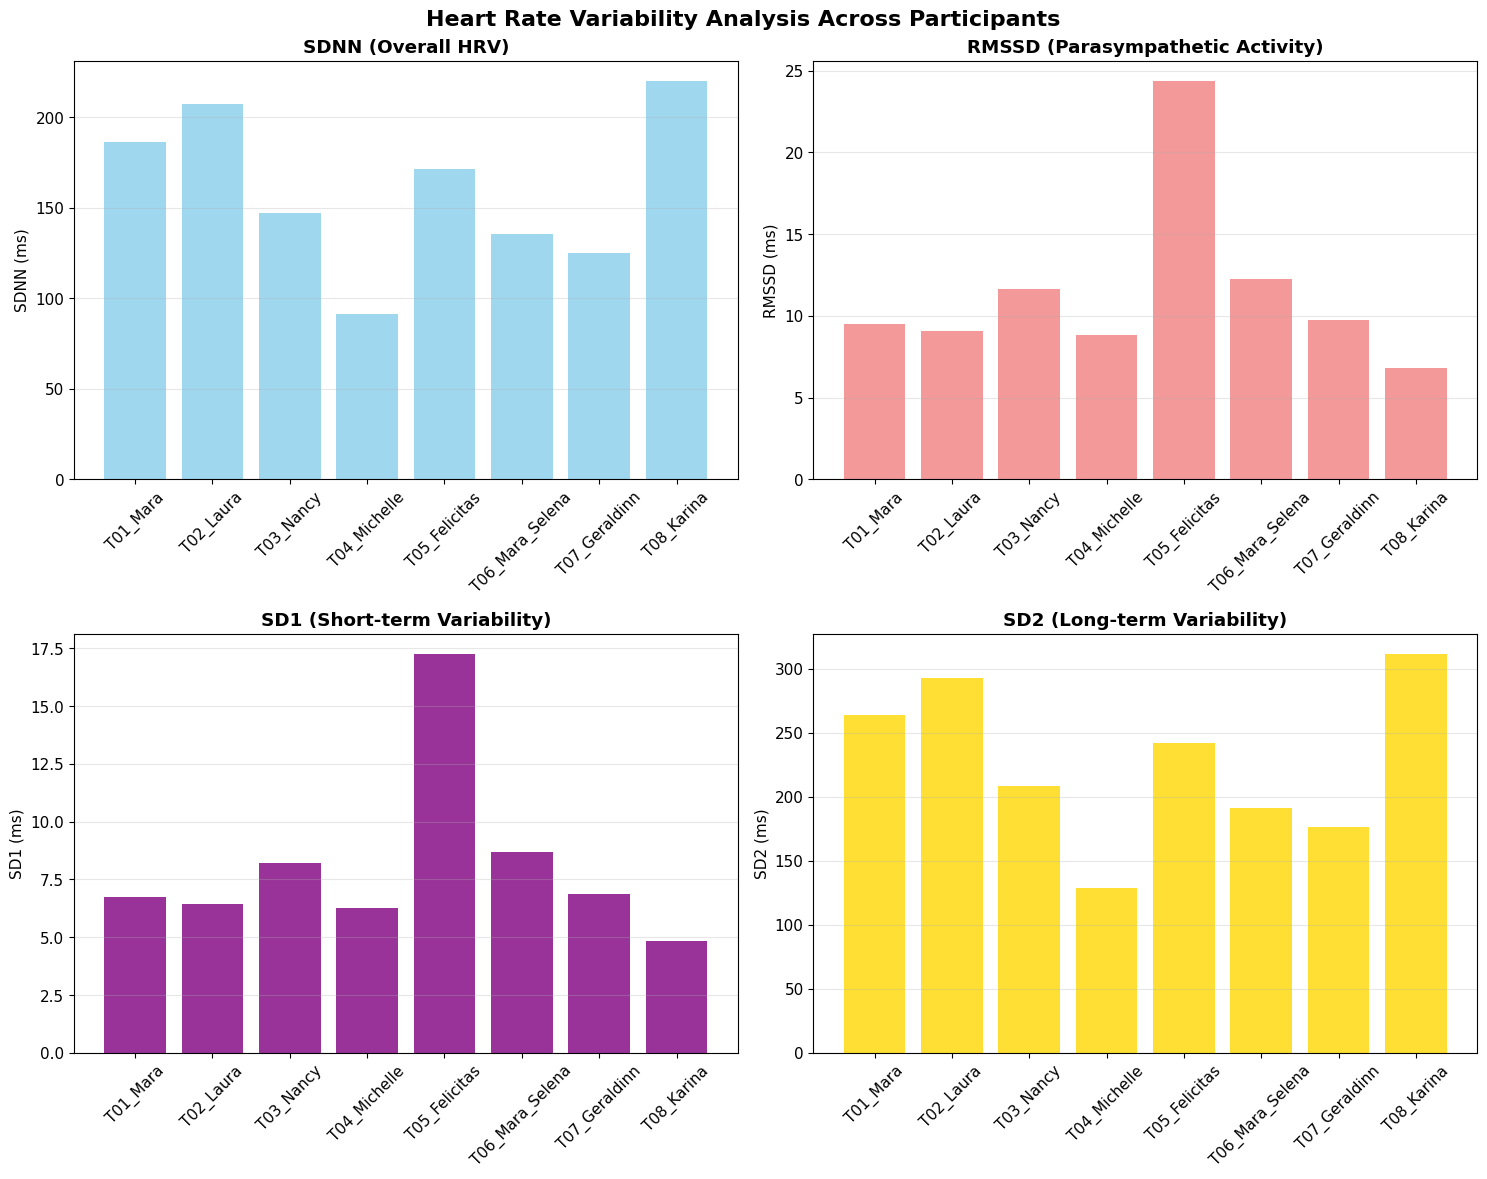

\nGenerating Individual Poincaré Plots...


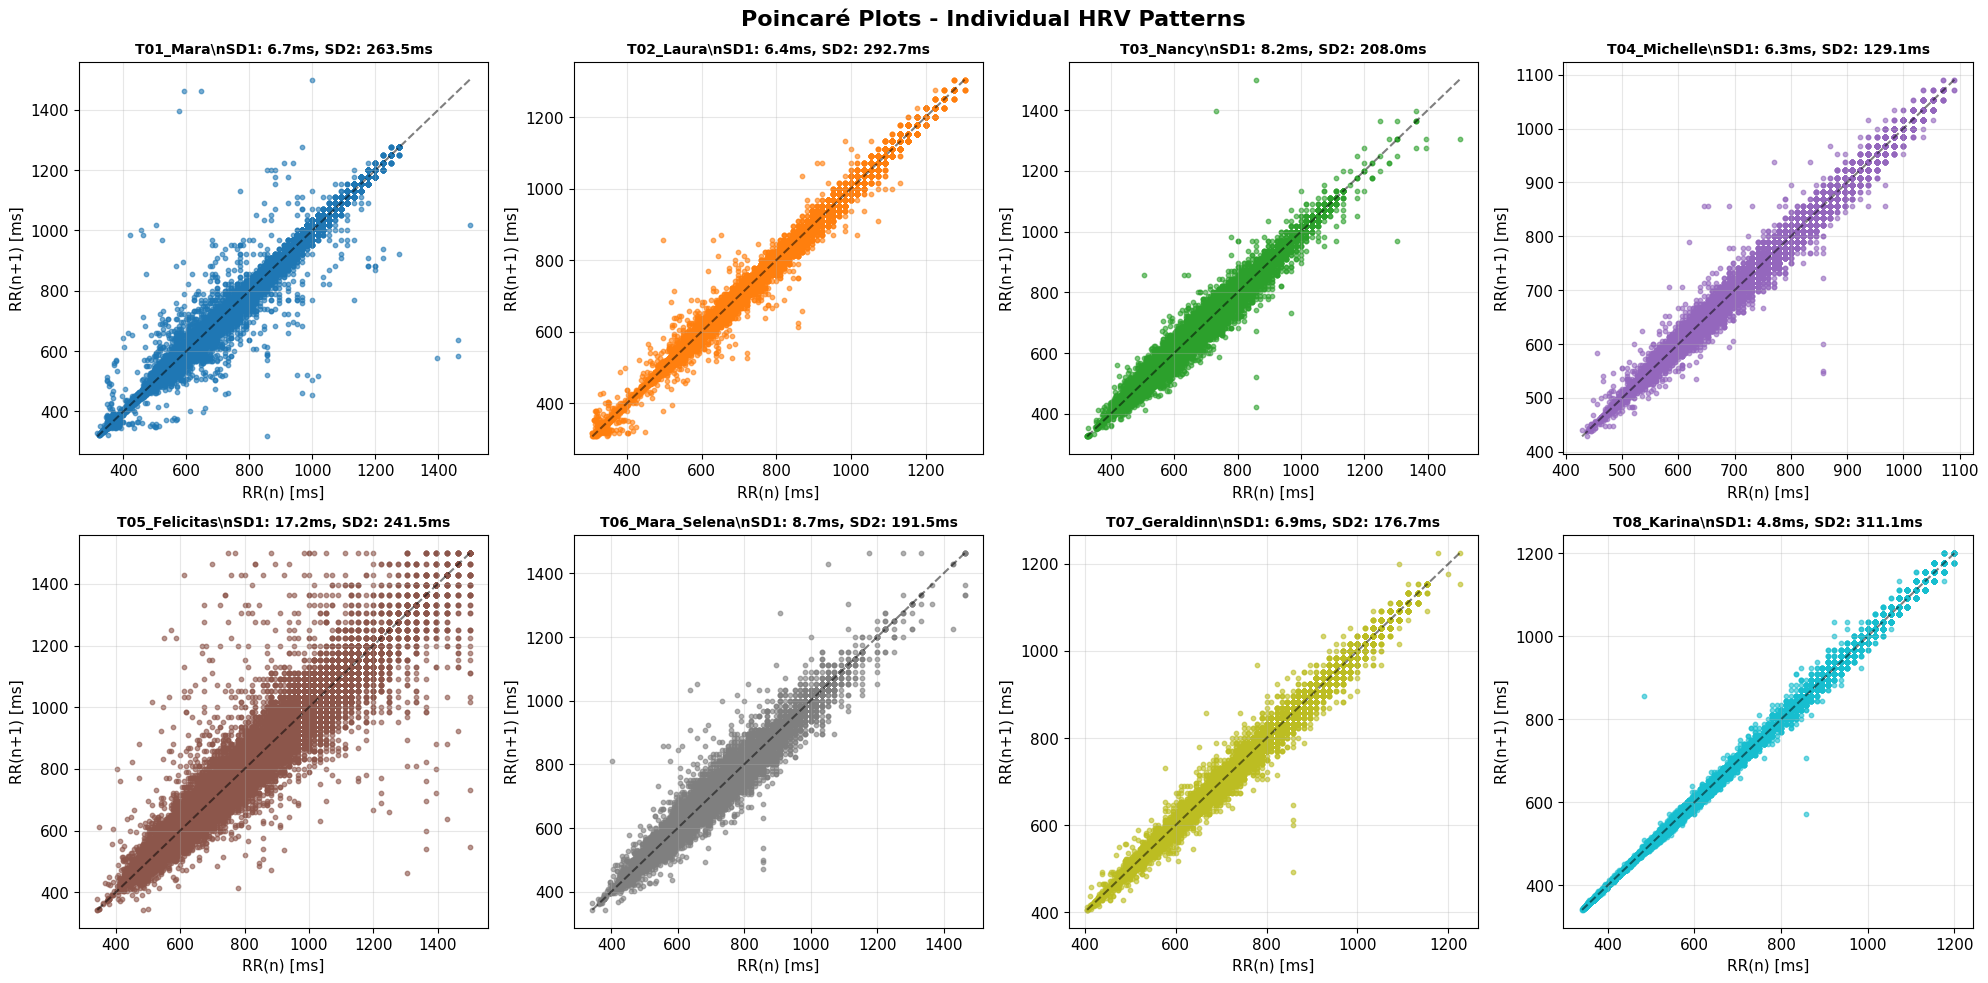

\nFIGURE CAPTIONS:
Figure 1: Comprehensive HRV analysis showing time-domain and Poincaré metrics
- SDNN: Standard deviation of NN intervals (overall HRV)
- RMSSD: Root mean square of successive differences (parasympathetic activity)
- SD1: Short-term variability from Poincaré plot
- SD2: Long-term variability from Poincaré plot

Figure 2: Individual Poincaré plots showing RR interval patterns
Each plot demonstrates the relationship between consecutive RR intervals.
The ellipse parameters SD1 and SD2 quantify heart rate variability patterns.


In [18]:
# Comprehensive HRV Visualization
if hrv_analysis_results and hrv_df is not None and len(hrv_df) > 0:
    
    print("GENERATING HRV VISUALIZATIONS")
    print("=" * 35)
    
    # Create the main visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Heart Rate Variability Analysis Across Participants', fontsize=16, fontweight='bold')
    
    # Time-domain metrics
    axes[0, 0].bar(hrv_df['Participant'], hrv_df['SDNN'], color='skyblue', alpha=0.8)
    axes[0, 0].set_title('SDNN (Overall HRV)', fontweight='bold')
    axes[0, 0].set_ylabel('SDNN (ms)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    axes[0, 1].bar(hrv_df['Participant'], hrv_df['RMSSD'], color='lightcoral', alpha=0.8)
    axes[0, 1].set_title('RMSSD (Parasympathetic Activity)', fontweight='bold')
    axes[0, 1].set_ylabel('RMSSD (ms)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Poincaré plot metrics
    axes[1, 0].bar(hrv_df['Participant'], hrv_df['SD1'], color='purple', alpha=0.8)
    axes[1, 0].set_title('SD1 (Short-term Variability)', fontweight='bold')
    axes[1, 0].set_ylabel('SD1 (ms)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    axes[1, 1].bar(hrv_df['Participant'], hrv_df['SD2'], color='gold', alpha=0.8)
    axes[1, 1].set_title('SD2 (Long-term Variability)', fontweight='bold')
    axes[1, 1].set_ylabel('SD2 (ms)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Individual Poincaré plots
    print("\\nGenerating Individual Poincaré Plots...")
    
    num_participants = len(rr_data)
    if num_participants > 0:
        rows = (num_participants + 3) // 4  # Calculate rows needed for 4 columns
        fig2, axes2 = plt.subplots(rows, 4, figsize=(20, 5*rows))
        fig2.suptitle('Poincaré Plots - Individual HRV Patterns', fontsize=16, fontweight='bold')
        
        # Ensure axes2 is 2D for consistent indexing
        if rows == 1:
            axes2 = axes2.reshape(1, -1)
        
        colors = plt.cm.tab10(np.linspace(0, 1, num_participants))
        
        for i, (participant_id, rr_intervals) in enumerate(rr_data.items()):
            if len(rr_intervals) > 50:
                row = i // 4
                col = i % 4
                
                # Create Poincaré plot data
                rr1 = rr_intervals[:-1]  # RR(n)
                rr2 = rr_intervals[1:]   # RR(n+1)
                
                # Plot the Poincaré plot
                axes2[row, col].scatter(rr1, rr2, alpha=0.6, s=10, color=colors[i])
                
                # Get SD1 and SD2 values from our results
                if participant_id in hrv_analysis_results:
                    sd1 = hrv_analysis_results[participant_id]['sd1']
                    sd2 = hrv_analysis_results[participant_id]['sd2']
                    title = f'{participant_id}\\nSD1: {sd1:.1f}ms, SD2: {sd2:.1f}ms'
                else:
                    title = f'{participant_id}'
                
                axes2[row, col].set_title(title, fontweight='bold', fontsize=10)
                axes2[row, col].set_xlabel('RR(n) [ms]')
                axes2[row, col].set_ylabel('RR(n+1) [ms]')
                axes2[row, col].grid(True, alpha=0.3)
                
                # Add identity line
                min_rr = min(rr1.min(), rr2.min())
                max_rr = max(rr1.max(), rr2.max())
                axes2[row, col].plot([min_rr, max_rr], [min_rr, max_rr], 'k--', alpha=0.5)
        
        # Hide any unused subplots
        for i in range(num_participants, rows * 4):
            row = i // 4
            col = i % 4
            axes2[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Print figure captions
    print("\\nFIGURE CAPTIONS:")
    print("="*20)
    print("Figure 1: Comprehensive HRV analysis showing time-domain and Poincaré metrics")
    print("- SDNN: Standard deviation of NN intervals (overall HRV)")
    print("- RMSSD: Root mean square of successive differences (parasympathetic activity)")
    print("- SD1: Short-term variability from Poincaré plot")
    print("- SD2: Long-term variability from Poincaré plot")
    print()
    print("Figure 2: Individual Poincaré plots showing RR interval patterns")
    print("Each plot demonstrates the relationship between consecutive RR intervals.")
    print("The ellipse parameters SD1 and SD2 quantify heart rate variability patterns.")
    
else:
    print("No HRV results available for visualization")
    print("Please run the previous analysis sections first")


✓ Data loaded successfully: 37 recordings
✓ Crew members: 8
✓ Sol range: 2 - 16
COMPREHENSIVE PARASYMPATHETIC ANALYSIS
Analyzing parasympathetic nervous system activity across crew members
Based on validated HRV metrics and scientific literature

1. Creating longitudinal trend analysis...


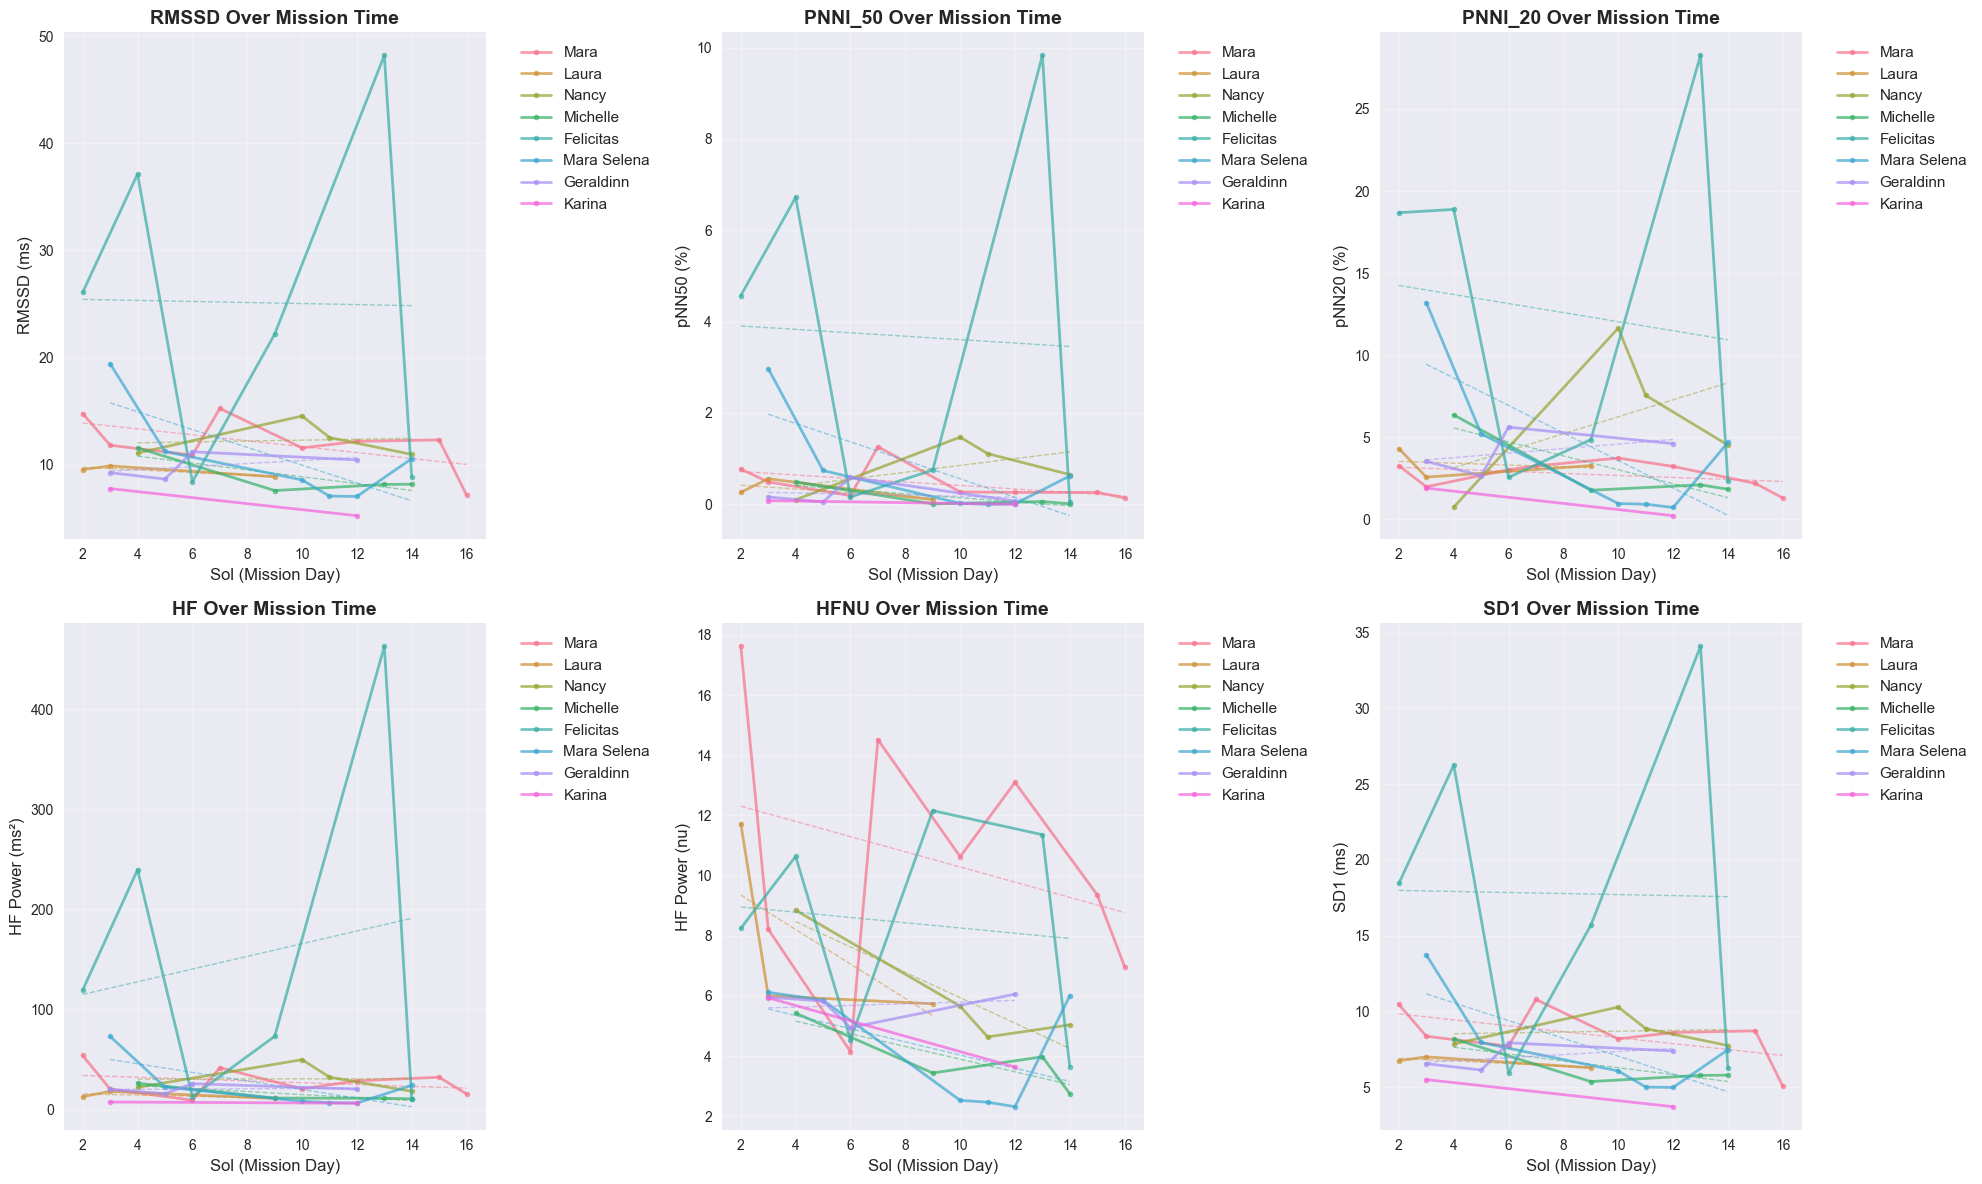

✓ Longitudinal trends plot saved to: ../parasympathetic_longitudinal.png
2. Creating crew comparison analysis...


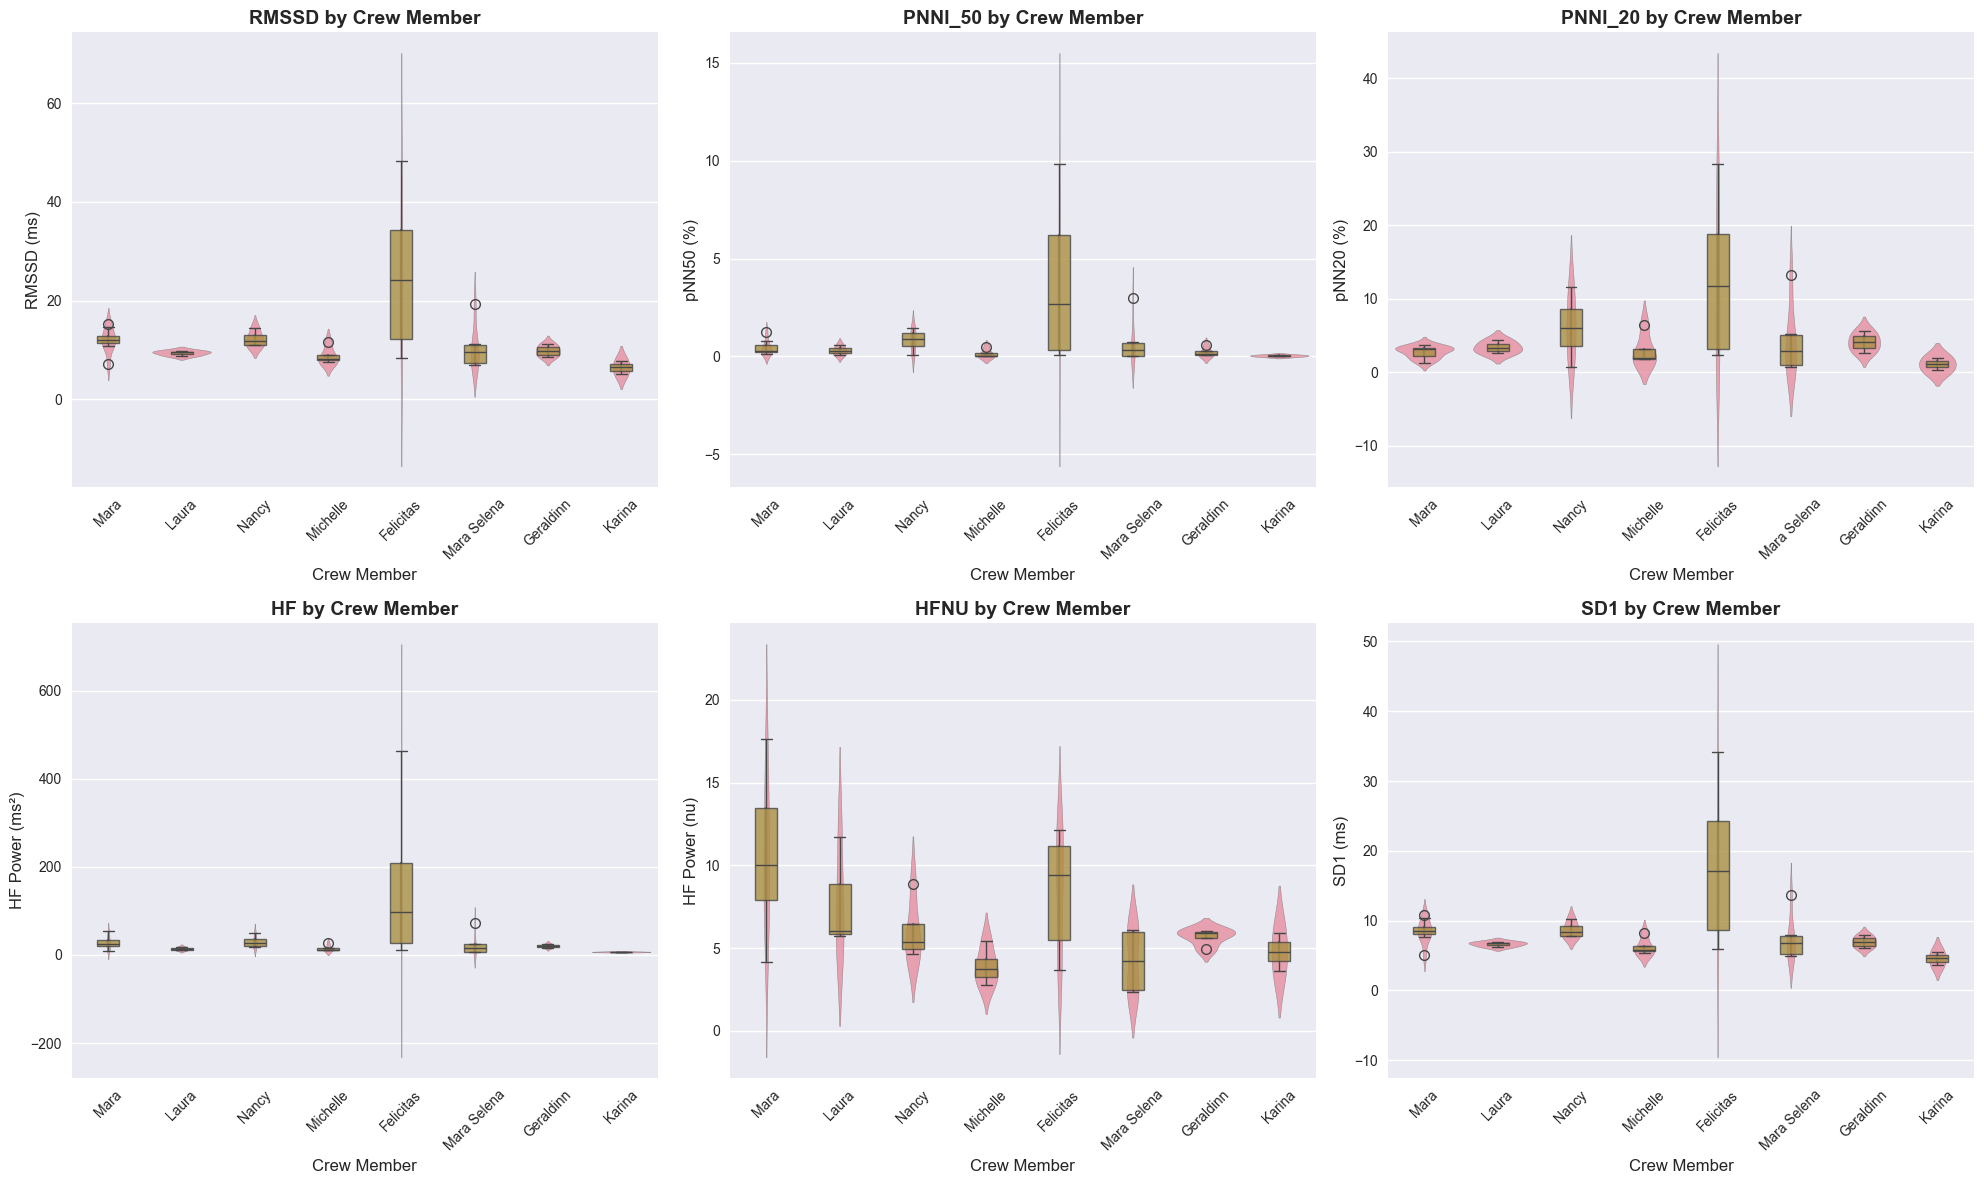

✓ Crew comparisons plot saved to: ../parasympathetic_comparisons.png
3. Creating mission phase analysis...


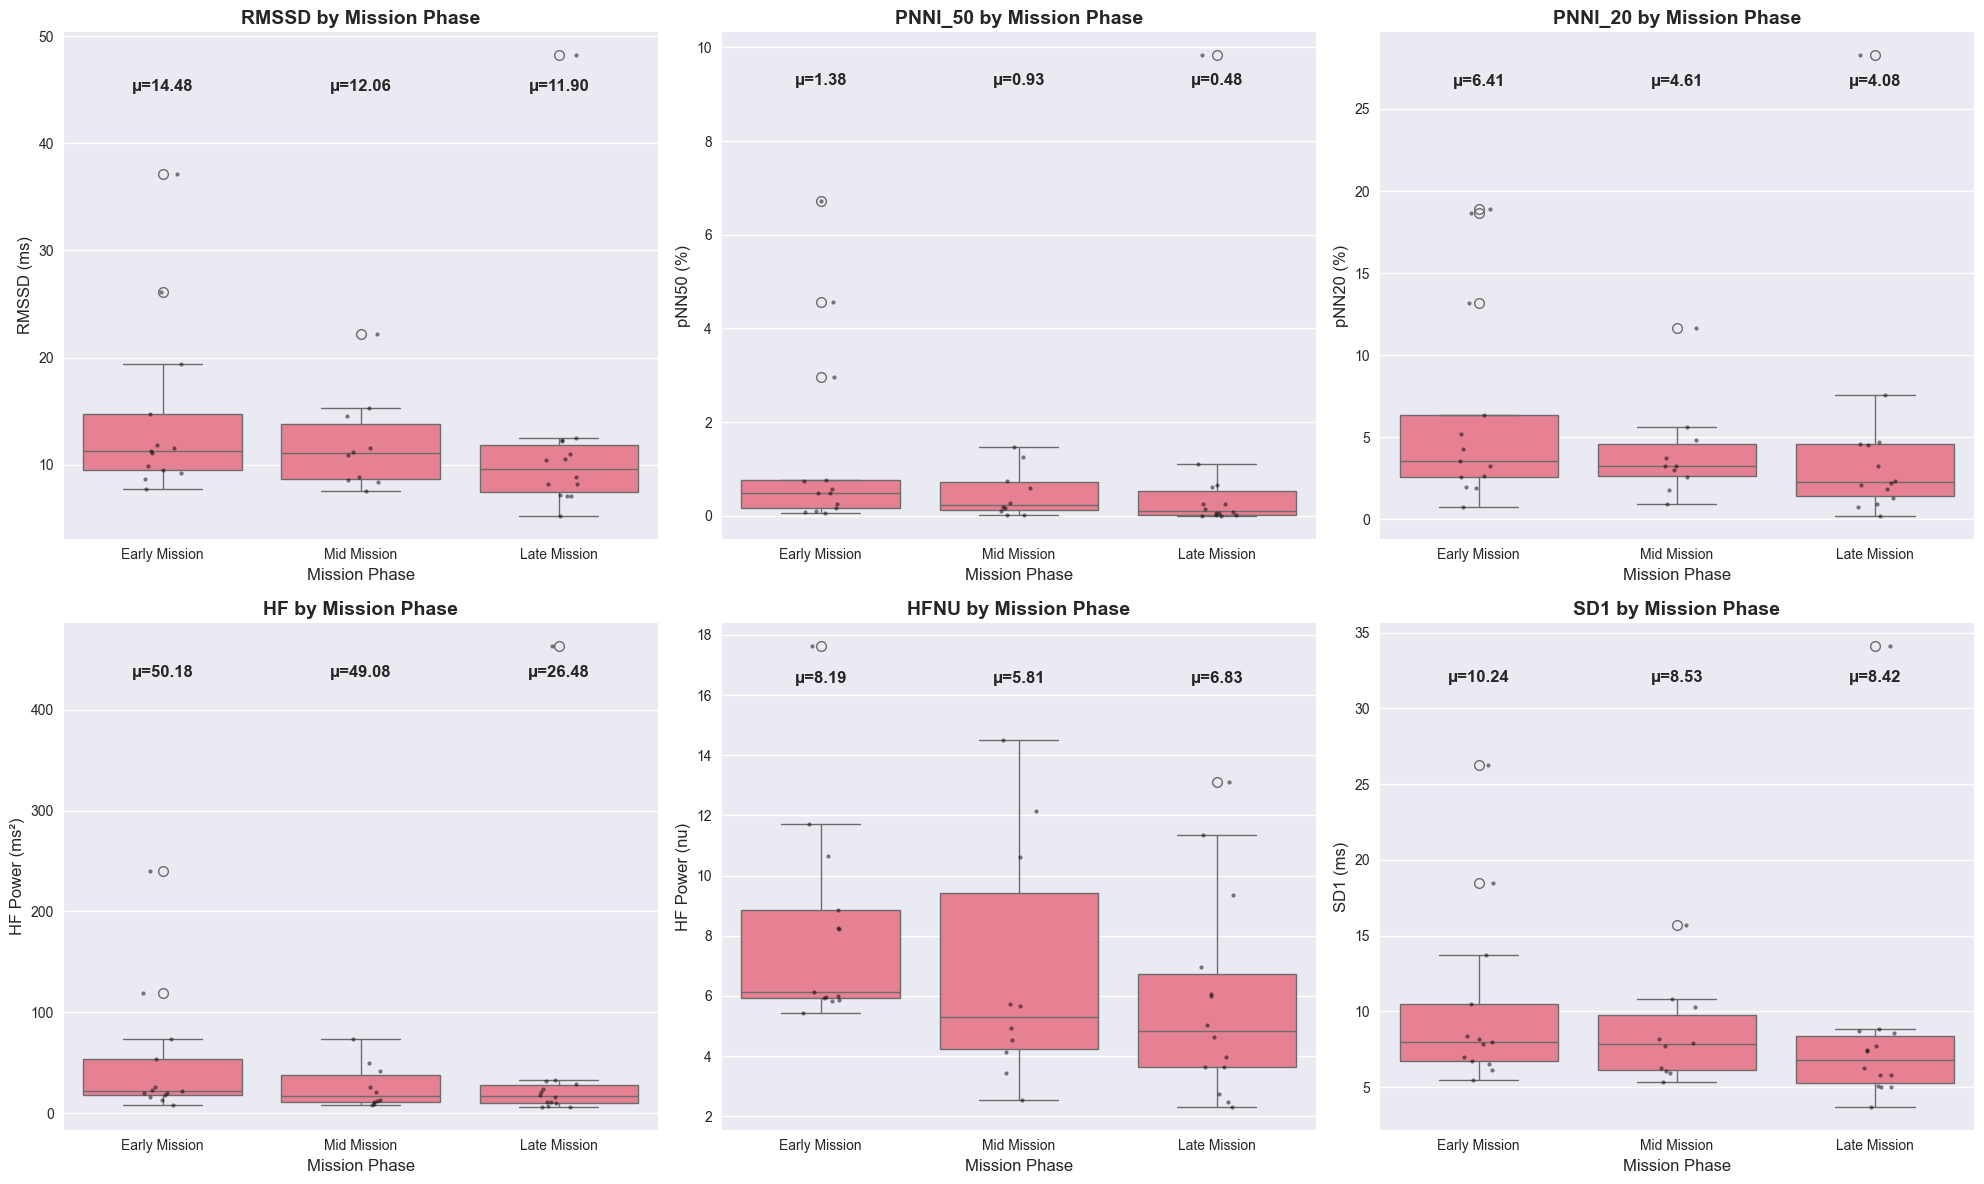

✓ Mission phase analysis plot saved to: ../parasympathetic_phases.png
4. Creating autonomic balance analysis...


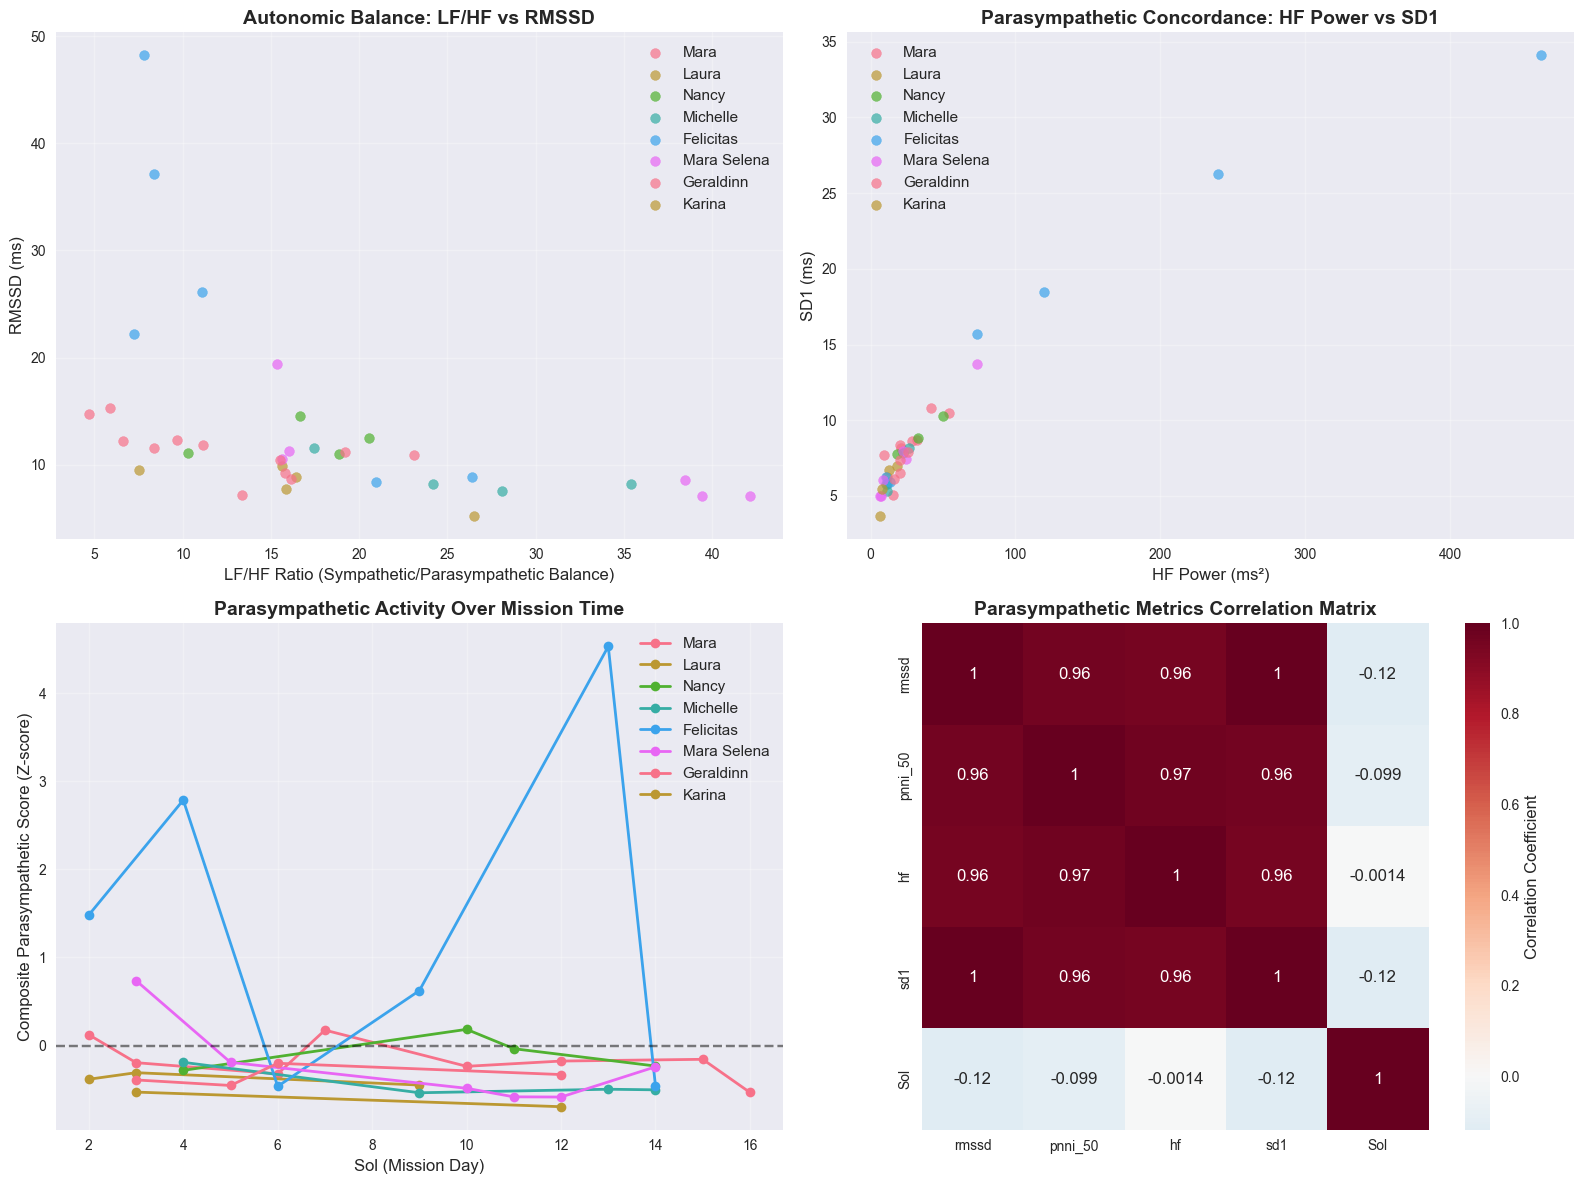

✓ Autonomic balance analysis plot saved to: ../autonomic_balance.png
5. Generating scientific report...
Performing One-Way ANOVA Tests
RMSSD    - F=3.400, p=0.0090 **
PNNI_50  - F=2.485, p=0.0396 *
PNNI_20  - F=2.354, p=0.0493 *
HF       - F=2.320, p=0.0523 ns
HFNU     - F=3.547, p=0.0071 **
SD1      - F=3.399, p=0.0090 **

Correlations with Mission Time (Sol)
RMSSD    - Pearson r=-0.118 (p=0.4856), Spearman r=-0.279 (p=0.0945)
PNNI_50  - Pearson r=-0.099 (p=0.5607), Spearman r=-0.308 (p=0.0640)
PNNI_20  - Pearson r=-0.135 (p=0.4271), Spearman r=-0.241 (p=0.1500)
HF       - Pearson r=-0.001 (p=0.9933), Spearman r=-0.214 (p=0.2033)
HFNU     - Pearson r=-0.279 (p=0.0946), Spearman r=-0.318 (p=0.0553)
SD1      - Pearson r=-0.118 (p=0.4855), Spearman r=-0.278 (p=0.0962)

Post-hoc Analysis (Tukey HSD)

RMSSD - Significant differences found:
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower    upper  reject
--------

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, ttest_ind, pearsonr, spearmanr
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

# Set style for high-quality plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11

class ParasympatheticAnalyzer:
    """
    Comprehensive analyzer for parasympathetic nervous system activity
    in space crew members using validated HRV metrics.
    """
    
    def __init__(self, data_path='../hrv_results/hrv_complete.csv'):
        """
        Initialize the analyzer with HRV data.
        
        Parameters:
        -----------
        data_path : str
            Path to the complete HRV results CSV file
        """
        self.data_path = data_path
        self.data = None
        self.parasympathetic_metrics = ['rmssd', 'pnni_50', 'pnni_20', 'hf', 'hfnu', 'sd1']
        self.crew_names = {
            'T01_Mara': 'Mara',
            'T02_Laura': 'Laura', 
            'T03_Nancy': 'Nancy',
            'T04_Michelle': 'Michelle',
            'T05_Felicitas': 'Felicitas',
            'T06_Mara_Selena': 'Mara Selena',
            'T07_Geraldinn': 'Geraldinn',
            'T08_Karina': 'Karina'
        }
        
        # Load data
        self.load_data()
        
    def load_data(self):
        """Load and prepare HRV data for analysis."""
        try:
            self.data = pd.read_csv(self.data_path)
            
            # Clean column names and ensure proper data types
            self.data['Subject'] = self.data['Subject'].astype(str)
            self.data['Sol'] = self.data['Sol'].astype(int)
            
            # Add friendly names
            self.data['Crew_Name'] = self.data['Subject'].map(self.crew_names)
            
            # Sort by subject and sol for proper time series analysis
            self.data = self.data.sort_values(['Subject', 'Sol'])
            
            # Create mission phase categories
            self.data['Mission_Phase'] = self.data['Sol'].apply(self._categorize_mission_phase)
            
            print(f"✓ Data loaded successfully: {len(self.data)} recordings")
            print(f"✓ Crew members: {len(self.data['Subject'].unique())}")
            print(f"✓ Sol range: {self.data['Sol'].min()} - {self.data['Sol'].max()}")
            
        except Exception as e:
            print(f"✗ Error loading data: {e}")
            raise
    
    def _categorize_mission_phase(self, sol):
        """Categorize mission phases based on Sol number."""
        if sol <= 5:
            return 'Early Mission'
        elif sol <= 10:
            return 'Mid Mission'
        else:
            return 'Late Mission'
    
    def calculate_parasympathetic_summary(self):
        """
        Calculate summary statistics for parasympathetic metrics.
        
        Returns:
        --------
        pd.DataFrame
            Summary statistics for each crew member and metric
        """
        summary_stats = []
        
        for crew in self.data['Subject'].unique():
            crew_data = self.data[self.data['Subject'] == crew]
            
            for metric in self.parasympathetic_metrics:
                if metric in crew_data.columns:
                    values = crew_data[metric].dropna()
                    if len(values) > 0:
                        summary_stats.append({
                            'Crew': self.crew_names[crew],
                            'Subject_ID': crew,
                            'Metric': metric,
                            'Mean': values.mean(),
                            'Median': values.median(),
                            'Std': values.std(),
                            'Min': values.min(),
                            'Max': values.max(),
                            'CV': values.std() / values.mean() * 100 if values.mean() != 0 else 0,
                            'N_recordings': len(values)
                        })
        
        return pd.DataFrame(summary_stats)
    
    def perform_statistical_analysis(self):
        """
        Perform comprehensive statistical analysis of parasympathetic metrics.
        
        Returns:
        --------
        dict
            Dictionary containing various statistical test results
        """
        results = {}
        
        # One-way ANOVA for each metric across crew members
        print("Performing One-Way ANOVA Tests")
        print("=" * 40)
        
        for metric in self.parasympathetic_metrics:
            if metric in self.data.columns:
                groups = [self.data[self.data['Subject'] == crew][metric].dropna().values 
                         for crew in self.data['Subject'].unique()]
                
                # Remove empty groups
                groups = [g for g in groups if len(g) > 0]
                
                if len(groups) >= 2:
                    f_stat, p_value = f_oneway(*groups)
                    results[f'anova_{metric}'] = {'F': f_stat, 'p': p_value}
                    
                    print(f"{metric.upper():8} - F={f_stat:.3f}, p={p_value:.4f} " +
                          f"{'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
        
        # Correlations with mission time (Sol)
        print("\nCorrelations with Mission Time (Sol)")
        print("=" * 40)
        
        for metric in self.parasympathetic_metrics:
            if metric in self.data.columns:
                clean_data = self.data[['Sol', metric]].dropna()
                if len(clean_data) > 3:
                    r_pearson, p_pearson = pearsonr(clean_data['Sol'], clean_data[metric])
                    r_spearman, p_spearman = spearmanr(clean_data['Sol'], clean_data[metric])
                    
                    results[f'corr_{metric}'] = {
                        'pearson_r': r_pearson, 'pearson_p': p_pearson,
                        'spearman_r': r_spearman, 'spearman_p': p_spearman
                    }
                    
                    print(f"{metric.upper():8} - Pearson r={r_pearson:.3f} (p={p_pearson:.4f}), " +
                          f"Spearman r={r_spearman:.3f} (p={p_spearman:.4f})")
        
        # Post-hoc tests (Tukey HSD) for significant ANOVA results
        print("\nPost-hoc Analysis (Tukey HSD)")
        print("=" * 40)
        
        for metric in self.parasympathetic_metrics:
            if metric in self.data.columns and f'anova_{metric}' in results:
                if results[f'anova_{metric}']['p'] < 0.05:
                    clean_data = self.data[['Subject', metric]].dropna()
                    if len(clean_data) > 0:
                        tukey_result = pairwise_tukeyhsd(
                            clean_data[metric], 
                            clean_data['Subject'], 
                            alpha=0.05
                        )
                        results[f'tukey_{metric}'] = tukey_result
                        print(f"\n{metric.upper()} - Significant differences found:")
                        print(tukey_result.summary())
        
        return results
    
    def plot_longitudinal_trends(self, save_path='../parasympathetic_longitudinal.png'):
        """
        Create comprehensive longitudinal trend plots for parasympathetic metrics.
        """
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.flatten()
        
        colors = sns.color_palette("husl", len(self.data['Subject'].unique()))
        
        for i, metric in enumerate(self.parasympathetic_metrics):
            if metric in self.data.columns:
                ax = axes[i]
                
                # Plot individual trajectories
                for j, crew in enumerate(self.data['Subject'].unique()):
                    crew_data = self.data[self.data['Subject'] == crew].sort_values('Sol')
                    
                    # Plot line
                    ax.plot(crew_data['Sol'], crew_data[metric], 
                           color=colors[j], alpha=0.7, linewidth=2,
                           label=self.crew_names[crew], marker='o', markersize=4)
                    
                    # Add trend line
                    if len(crew_data) > 2:
                        z = np.polyfit(crew_data['Sol'], crew_data[metric], 1)
                        p = np.poly1d(z)
                        ax.plot(crew_data['Sol'], p(crew_data['Sol']), 
                               color=colors[j], linestyle='--', alpha=0.5, linewidth=1)
                
                ax.set_title(f'{metric.upper()} Over Mission Time', fontsize=14, fontweight='bold')
                ax.set_xlabel('Sol (Mission Day)', fontsize=12)
                ax.set_ylabel(self._get_metric_label(metric), fontsize=12)
                ax.grid(True, alpha=0.3)
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Longitudinal trends plot saved to: {save_path}")
    
    def plot_crew_comparisons(self, save_path='../parasympathetic_comparisons.png'):
        """
        Create box plots and violin plots for crew comparisons.
        """
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.flatten()
        
        for i, metric in enumerate(self.parasympathetic_metrics):
            if metric in self.data.columns:
                ax = axes[i]
                
                # Create violin plot with box plot overlay
                sns.violinplot(data=self.data, x='Crew_Name', y=metric, ax=ax, alpha=0.7)
                sns.boxplot(data=self.data, x='Crew_Name', y=metric, ax=ax, 
                           boxprops=dict(alpha=0.8), width=0.3)
                
                ax.set_title(f'{metric.upper()} by Crew Member', fontsize=14, fontweight='bold')
                ax.set_xlabel('Crew Member', fontsize=12)
                ax.set_ylabel(self._get_metric_label(metric), fontsize=12)
                ax.tick_params(axis='x', rotation=45)
                
                # Add statistical annotations
                self._add_statistical_annotations(ax, metric)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Crew comparisons plot saved to: {save_path}")
    
    def plot_mission_phase_analysis(self, save_path='../parasympathetic_phases.png'):
        """
        Analyze parasympathetic activity across mission phases.
        """
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.flatten()
        
        for i, metric in enumerate(self.parasympathetic_metrics):
            if metric in self.data.columns:
                ax = axes[i]
                
                # Create box plot by mission phase
                sns.boxplot(data=self.data, x='Mission_Phase', y=metric, ax=ax)
                
                # Add individual points
                sns.stripplot(data=self.data, x='Mission_Phase', y=metric, 
                             ax=ax, color='black', alpha=0.5, size=3)
                
                ax.set_title(f'{metric.upper()} by Mission Phase', fontsize=14, fontweight='bold')
                ax.set_xlabel('Mission Phase', fontsize=12)
                ax.set_ylabel(self._get_metric_label(metric), fontsize=12)
                
                # Calculate mean values for each phase
                phase_means = self.data.groupby('Mission_Phase')[metric].mean()
                for j, phase in enumerate(phase_means.index):
                    ax.text(j, ax.get_ylim()[1] * 0.9, f'μ={phase_means[phase]:.2f}', 
                           ha='center', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Mission phase analysis plot saved to: {save_path}")
    
    def plot_autonomic_balance(self, save_path='../autonomic_balance.png'):
        """
        Create autonomic balance analysis using LF/HF ratio and parasympathetic metrics.
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot 1: LF/HF ratio vs RMSSD
        ax1 = axes[0, 0]
        for crew in self.data['Subject'].unique():
            crew_data = self.data[self.data['Subject'] == crew]
            ax1.scatter(crew_data['lf_hf_ratio'], crew_data['rmssd'], 
                       label=self.crew_names[crew], alpha=0.7, s=50)
        
        ax1.set_xlabel('LF/HF Ratio (Sympathetic/Parasympathetic Balance)', fontsize=12)
        ax1.set_ylabel('RMSSD (ms)', fontsize=12)
        ax1.set_title('Autonomic Balance: LF/HF vs RMSSD', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: HF power vs SD1
        ax2 = axes[0, 1]
        for crew in self.data['Subject'].unique():
            crew_data = self.data[self.data['Subject'] == crew]
            ax2.scatter(crew_data['hf'], crew_data['sd1'], 
                       label=self.crew_names[crew], alpha=0.7, s=50)
        
        ax2.set_xlabel('HF Power (ms²)', fontsize=12)
        ax2.set_ylabel('SD1 (ms)', fontsize=12)
        ax2.set_title('Parasympathetic Concordance: HF Power vs SD1', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Parasympathetic composite score over time
        ax3 = axes[1, 0]
        
        # Create composite parasympathetic score (z-score normalized)
        parasympa_metrics = ['rmssd', 'pnni_50', 'hf', 'sd1']
        composite_data = self.data.copy()
        
        for metric in parasympa_metrics:
            if metric in composite_data.columns:
                composite_data[f'{metric}_z'] = stats.zscore(composite_data[metric], nan_policy='omit')
        
        # Calculate composite score
        z_columns = [f'{metric}_z' for metric in parasympa_metrics if f'{metric}_z' in composite_data.columns]
        composite_data['parasympathetic_score'] = composite_data[z_columns].mean(axis=1)
        
        for crew in self.data['Subject'].unique():
            crew_data = composite_data[composite_data['Subject'] == crew].sort_values('Sol')
            ax3.plot(crew_data['Sol'], crew_data['parasympathetic_score'], 
                    label=self.crew_names[crew], marker='o', linewidth=2)
        
        ax3.set_xlabel('Sol (Mission Day)', fontsize=12)
        ax3.set_ylabel('Composite Parasympathetic Score (Z-score)', fontsize=12)
        ax3.set_title('Parasympathetic Activity Over Mission Time', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        # Plot 4: Correlation heatmap
        ax4 = axes[1, 1]
        
        # Select parasympathetic metrics for correlation
        para_cols = [col for col in parasympa_metrics if col in self.data.columns]
        corr_data = self.data[para_cols + ['Sol']].corr()
        
        sns.heatmap(corr_data, annot=True, cmap='RdBu_r', center=0, 
                   square=True, ax=ax4, cbar_kws={'label': 'Correlation Coefficient'})
        ax4.set_title('Parasympathetic Metrics Correlation Matrix', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Autonomic balance analysis plot saved to: {save_path}")
    
    def _get_metric_label(self, metric):
        """Get proper label for metric with units."""
        labels = {
            'rmssd': 'RMSSD (ms)',
            'pnni_50': 'pNN50 (%)',
            'pnni_20': 'pNN20 (%)',
            'hf': 'HF Power (ms²)',
            'hfnu': 'HF Power (nu)',
            'sd1': 'SD1 (ms)'
        }
        return labels.get(metric, metric)
    
    def _add_statistical_annotations(self, ax, metric):
        """Add statistical significance annotations to plots."""
        # This is a simplified version - in practice, you'd want to perform
        # pairwise tests and add significance bars
        pass
    
    def generate_scientific_report(self, save_path='../parasympathetic_report.txt'):
        """
        Generate a comprehensive scientific report of the parasympathetic analysis.
        """
        report = []
        
        # Header
        report.append("PARASYMPATHETIC NERVOUS SYSTEM ANALYSIS REPORT")
        report.append("=" * 60)
        report.append("")
        
        # Introduction
        report.append("INTRODUCTION")
        report.append("-" * 20)
        report.append("This analysis examines parasympathetic nervous system activity in space crew")
        report.append("members using validated heart rate variability (HRV) metrics. Parasympathetic")
        report.append("activity reflects the body's 'rest and digest' response and is crucial for")
        report.append("cardiovascular health, stress recovery, and overall autonomic balance.")
        report.append("")
        
        # Methodology
        report.append("METHODOLOGY")
        report.append("-" * 20)
        report.append("Parasympathetic activity was assessed using established HRV metrics:")
        report.append("• RMSSD: Root mean square of successive RR interval differences")
        report.append("• pNN50: Percentage of successive RR intervals differing by >50ms")
        report.append("• pNN20: Percentage of successive RR intervals differing by >20ms")
        report.append("• HF Power: High frequency power (0.15-0.4 Hz) from spectral analysis")
        report.append("• HFnu: HF power in normalized units")
        report.append("• SD1: Short-term variability from Poincaré plot analysis")
        report.append("")
        
        # Results
        report.append("RESULTS")
        report.append("-" * 20)
        
        # Summary statistics
        summary_stats = self.calculate_parasympathetic_summary()
        report.append("Summary Statistics by Crew Member:")
        report.append("")
        
        for crew in summary_stats['Crew'].unique():
            crew_stats = summary_stats[summary_stats['Crew'] == crew]
            report.append(f"{crew}:")
            for _, row in crew_stats.iterrows():
                report.append(f"  {row['Metric'].upper()}: {row['Mean']:.2f} ± {row['Std']:.2f} "
                             f"(range: {row['Min']:.2f}-{row['Max']:.2f})")
            report.append("")
        
        # Statistical analysis
        stats_results = self.perform_statistical_analysis()
        
        report.append("Statistical Analysis:")
        report.append("")
        
        # ANOVA results
        report.append("Between-crew differences (One-way ANOVA):")
        for metric in self.parasympathetic_metrics:
            if f'anova_{metric}' in stats_results:
                result = stats_results[f'anova_{metric}']
                sig_level = "***" if result['p'] < 0.001 else "**" if result['p'] < 0.01 else "*" if result['p'] < 0.05 else "ns"
                report.append(f"  {metric.upper()}: F={result['F']:.3f}, p={result['p']:.4f} {sig_level}")
        
        report.append("")
        
        # Correlations with time
        report.append("Correlations with mission time:")
        for metric in self.parasympathetic_metrics:
            if f'corr_{metric}' in stats_results:
                result = stats_results[f'corr_{metric}']
                report.append(f"  {metric.upper()}: r={result['pearson_r']:.3f}, p={result['pearson_p']:.4f}")
        
        # Clinical interpretation
        report.append("")
        report.append("CLINICAL INTERPRETATION")
        report.append("-" * 30)
        report.append("Higher values in parasympathetic metrics (RMSSD, pNN50, HF power, SD1)")
        report.append("indicate greater parasympathetic activity and better autonomic balance.")
        report.append("Lower values may suggest sympathetic dominance, stress, or fatigue.")
        report.append("")
        
        # Conclusions
        report.append("CONCLUSIONS")
        report.append("-" * 20)
        report.append("This analysis provides comprehensive insights into parasympathetic nervous")
        report.append("system activity across crew members throughout the mission timeline.")
        report.append("Individual variations and temporal patterns can inform personalized")
        report.append("countermeasures and health monitoring strategies.")
        report.append("")
        
        # Save report
        with open(save_path, 'w') as f:
            f.write('\n'.join(report))
        
        print(f"✓ Scientific report saved to: {save_path}")
        
        return '\n'.join(report)
    
    def run_complete_analysis(self):
        """
        Run the complete parasympathetic analysis pipeline.
        """
        print("COMPREHENSIVE PARASYMPATHETIC ANALYSIS")
        print("=" * 50)
        print("Analyzing parasympathetic nervous system activity across crew members")
        print("Based on validated HRV metrics and scientific literature")
        print()
        
        # Generate all plots
        print("1. Creating longitudinal trend analysis...")
        self.plot_longitudinal_trends()
        
        print("2. Creating crew comparison analysis...")
        self.plot_crew_comparisons()
        
        print("3. Creating mission phase analysis...")
        self.plot_mission_phase_analysis()
        
        print("4. Creating autonomic balance analysis...")
        self.plot_autonomic_balance()
        
        # Generate report
        print("5. Generating scientific report...")
        report = self.generate_scientific_report()
        
        # Statistical analysis
        print("6. Performing statistical analysis...")
        stats_results = self.perform_statistical_analysis()
        
        print("\n" + "=" * 50)
        print("ANALYSIS COMPLETE!")
        print("=" * 50)
        print("Generated files:")
        print("• parasympathetic_longitudinal.png - Longitudinal trends")
        print("• parasympathetic_comparisons.png - Crew comparisons")
        print("• parasympathetic_phases.png - Mission phase analysis")
        print("• autonomic_balance.png - Autonomic balance analysis")
        print("• parasympathetic_report.txt - Scientific report")
        
        return stats_results


# Main execution
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = ParasympatheticAnalyzer()
    
    # Run complete analysis
    results = analyzer.run_complete_analysis()
    
    print("\nParasympathetic analysis completed successfully!")
    print("All plots and reports have been saved to the working_folder directory.") 